<a href="https://colab.research.google.com/github/swilsonmfc/unsupervised/blob/main/GMM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian Mixture Models

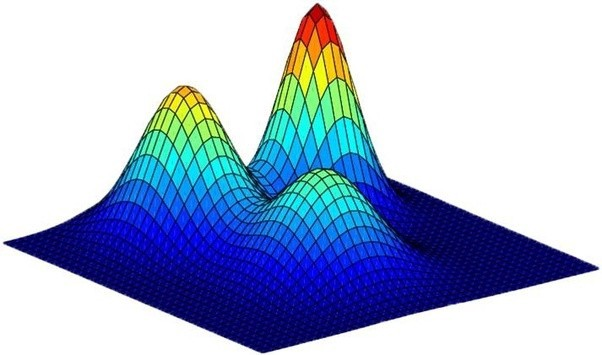

# Install

# Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as pat
import matplotlib.transforms as transforms
import seaborn

from ipywidgets import interact
import ipywidgets as widgets

from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture

from sklearn.datasets import load_iris
from sklearn.datasets import make_blobs

In [ ]:
%matplotlib inline

# Intuition

## Gaussians
* Univariate Gaussian
* Defined by two parameters
* mu - mean
* sigma - Standard deviation
* http://jrmeyer.github.io/machinelearning/2017/08/18/mle.html

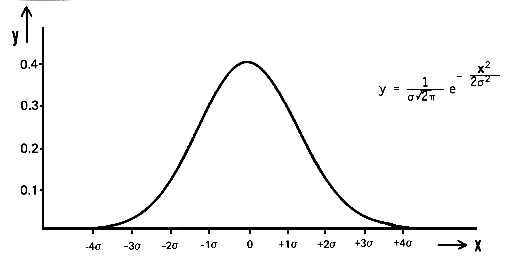

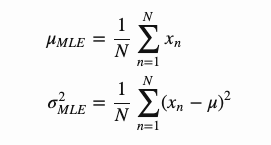

## Mixtures

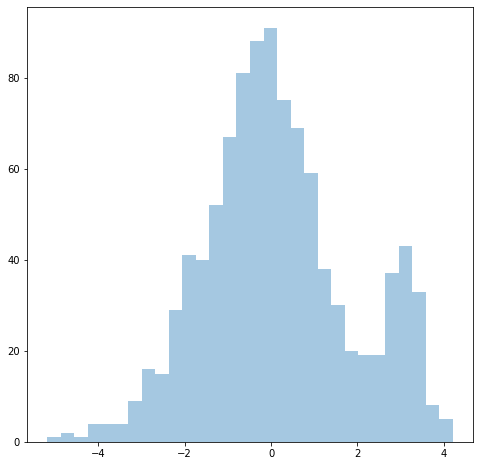

In [ ]:
random_state = np.random.RandomState(seed=1)

X = np.concatenate([random_state.normal(-1, 1.5, 350),
                    random_state.normal(0, 1, 500),
                    random_state.normal(3, 0.5, 150)]).reshape(-1, 1)

plt.figure(figsize=(8, 8))
plt.hist(X, bins=30, alpha=0.4);

## Models

In [ ]:
N = np.arange(1, 11)
models = [GaussianMixture(i).fit(X) for i in N]
AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]

In [ ]:
best = models[np.argmin(AIC)]

## Mixture

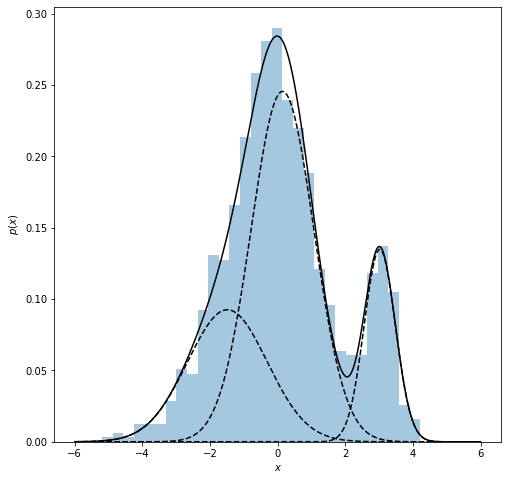

In [ ]:
x = np.linspace(-6, 6, 1000)
logprob = best.score_samples(x.reshape(-1, 1))
responsibilities = best.predict_proba(x.reshape(-1, 1))
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

plt.figure(figsize=(8, 8))
ax = plt.gca()
ax.hist(X, 30, density=True, histtype='stepfilled', alpha=0.4)
ax.plot(x, pdf, '-k')
ax.plot(x, pdf_individual, '--k')
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$');

## Responsibilities
* Responsibilities are like soft labels. 
* They tell which Gaussian each data point is more likely to come from

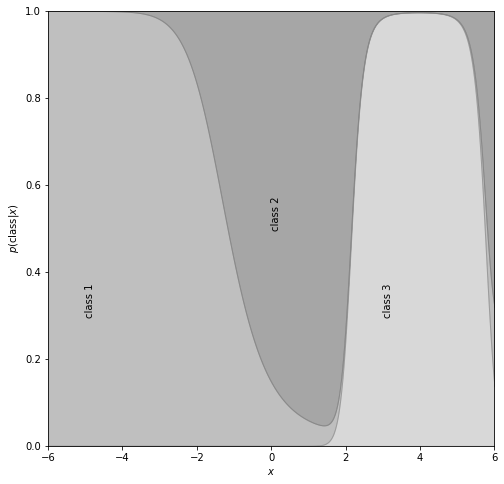

In [ ]:
p = responsibilities
p = p[:, (1, 0, 2)]  # rearrange order so the plot looks better
p = p.cumsum(1).T

plt.figure(figsize=(8, 8))
ax = plt.gca()
ax.fill_between(x, 0, p[0], color='gray', alpha=0.3)
ax.fill_between(x, p[0], p[1], color='gray', alpha=0.5)
ax.fill_between(x, p[1], 1, color='gray', alpha=0.7)
ax.set_xlim(-6, 6)
ax.set_ylim(0, 1)
ax.set_xlabel('$x$')
ax.set_ylabel(r'$p({\rm class}|x)$')

ax.text(-5, 0.3, 'class 1', rotation='vertical')
ax.text(0, 0.5, 'class 2', rotation='vertical')
ax.text(3, 0.3, 'class 3', rotation='vertical')

plt.show();

# Data

In [ ]:
X_iris, y_iris = load_iris(return_X_y=True)

In [ ]:
X_iris[0:5]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

# Implementation
* Initialize two Gaussians with random parameters 
* Iterate between two steps 
  * Estimate the labels while keeping the parameters fixed 
  * Update the parameters while keeping the label fixed 
* Eventually reach a local optimum
* https://towardsdatascience.com/gaussian-mixture-model-clearly-explained-115010f7d4cf

In [ ]:
class GMM:
  def __init__(self, n_gaussians):
    self.n_gaussians = n_gaussians
    self.phi         = [1 / n_gaussians] * n_gaussians 
    
    self.size = None # Size of data
    self.d    = None # Dimensions

    self.mu   = None # Means
    self.cov  = None # Covariances
    self.R    = None # R 
    self.N    = None # N
    
  def mv_normal(self, X, mu, cov):
    # Compute the Multivariate Notmal
    mvn = ((2 * np.pi) ** self.size) ** -0.5 \
           * np.linalg.det(cov) ** -0.5 \
           * np.exp(-0.5 * np.dot(np.dot((X - mu).T, np.linalg.inv(cov)), (X - mu)))
    return mvn

  def initialize(self, X):
    # Initialize sizes, means & covariances
    # This is a convenient implementation rather than robust approach
    shape = X.shape
    self.size = shape[0]
    self.d = 1 if len(shape) == 1 else X.shape[1]

    _X = np.array_split(X, self.n_gaussians)
    self.mu  = [np.mean(x, axis=0) for x in _X]
    self.cov = [np.cov(x.T) for x in _X]

  def fit(self, X, iterations=100):
    # Initalize and run EM
    # We stop after a number of iterations, but we could
    # Run until the negative log-likelihood reaches a threshold
    self.initialize(X)
    for i in range(iterations):
      self.expectation_maximization(X)
    return self

  def step(self, X):
    # Perform one step of EM
    self.expectation_maximization(X)

  def expectation_maximization(self, X):
    # Expectation Step
    #   Evaluate responsibilities (R)
    self.R = np.zeros( (self.size, self.n_gaussians) )
    for n in range(self.size): 
      for k in range(self.n_gaussians):
        self.R[n][k] = self.phi[k] * self.mv_normal(X[n], self.mu[k], self.cov[k])
        self.R[n][k] /= sum([self.phi[j] * self.mv_normal(X[n], self.mu[j], self.cov[j]) \
                             for j in range(self.n_gaussians)])
    self.N = np.sum(self.R, axis=0) 

    # Maximization - Evaluate means & covariances
    #   Means
    self.mu = np.zeros( (self.n_gaussians, self.d) )
    for k in range(self.n_gaussians):
      for n in range(self.size):
        self.mu[k] += self.R[n][k] * X[n]
    self.mu = [1 / self.N[k] * self.mu[k] for k in range(self.n_gaussians)]

    #   Covariances
    self.cov = [np.zeros((self.d, self.d)) for k in range(self.n_gaussians)]
    for k in range(self.n_gaussians):
      self.cov[k] = np.cov(X.T, aweights=(self.R[:,k]), ddof=0)
    self.cov = [1 / self.N[k] * self.cov[k] for k in range(self.n_gaussians)]
    self.phi = [self.N[k] / len(X) for k in range(self.n_gaussians)]

  def predict_proba(self, X):
    # Predict Probabilities
    probas = []
    for n in range(self.size):
      mvn = [self.mv_normal(X[n], self.mu[k], self.cov[k]) for k in range(self.n_gaussians)]
      probas.append([mvn])
    return np.squeeze(probas)

  def predict(self, X):
    # Predict Clusters
    probas = self.predict_proba(X)
    return np.argmax(probas, axis=1)    

In [ ]:
GMM(n_gaussians=3).fit(X_iris).predict(X_iris)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
GaussianMixture(n_components=3).fit(X_iris).predict(X_iris)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

## Data

In [ ]:
X, y = make_blobs(n_samples=[10, 10], n_features=2, random_state=100, centers=[[3, 4], [4, 5]])
X

array([[2.64360095, 3.76756549],
       [2.46871962, 5.02973269],
       [3.22117967, 2.92995667],
       [4.75044476, 4.54405307],
       [1.25023453, 4.3426804 ],
       [2.56186438, 2.88168175],
       [3.67376194, 5.05567601],
       [4.18451869, 5.9370822 ],
       [4.1530358 , 3.74756396],
       [3.24364769, 5.81645401],
       [4.73100034, 6.36155613],
       [5.18962227, 3.30938317],
       [5.61898166, 6.54160517],
       [3.98132079, 4.51421884],
       [4.22239961, 3.556783  ],
       [2.41640495, 4.81684707],
       [3.67272081, 3.89558886],
       [2.54197301, 4.43516349],
       [2.81050417, 4.25500144],
       [3.74812086, 4.15756426]])

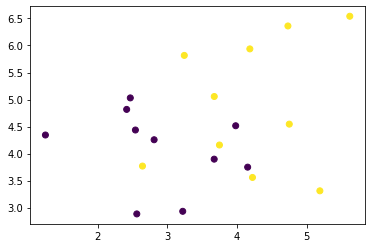

In [ ]:
plt.scatter(X[:,0], X[:,1], c=y);

## Interactive

In [ ]:
def output_data(out, gmm):
  pred = gmm.predict(X)
  output.clear_output(True) 

  ax = plt.gca()
  ax.scatter(X[:,0], X[:,1], c=pred)
  
  counter = 0
  for mu, cov, color in zip(gmm.mu, gmm.cov, ['red', 'green']):
    counter += 1
    print(f'Gaussian {counter}')
    print(f'  Mean {mu}')
    print(f'  Covariance')
    print(cov)
    print('\n')

    ax.scatter(mu[0], mu[1], marker='X', color=color, s=50);

    v, w = np.linalg.eigh(cov)
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi # convert to degrees
    ellipse = pat.Ellipse(mu, v[0], v[1], 180 + angle, color=color)
    ellipse.set_alpha(0.1)
    ax.add_patch(ellipse)
  plt.show();

In [ ]:
# Widgets
button = widgets.Button(description='Step')
output = widgets.Output()

# Initialize
gmm = GMM(n_gaussians=2)
gmm.initialize(X)
with output:
  output_data(output, gmm)

# Button Clicks
display(button, output)
def clicked(b):
  with output:
    gmm.step(X)
    output_data(output, gmm)
button.on_click(clicked)

Button(description='Step', style=ButtonStyle())

Output()

# GaussianMixture

In [ ]:
gmm = GaussianMixture(n_components=3)
gmm.fit(X_iris)

GaussianMixture(n_components=3)

## Optimal Clusters

In [ ]:
gmm.aic(X_iris), gmm.bic(X_iris)

(448.39147182920397, 580.8594247694392)

In [ ]:
N = [i for i in range(2, 11)]
models = [GaussianMixture(i).fit(X_iris) for i in N]
AIC = [m.aic(X_iris) for m in models]
BIC = [m.bic(X_iris) for m in models]

In [ ]:
pd.DataFrame({
    'Components': N,
    'AIC': AIC,
    'BIC': BIC
}).set_index('Components')

,AIC,BIC
Components,,
2,486.709409,574.017833
3,448.391472,580.859425
4,456.150924,633.778407
5,447.532600,670.319612
6,476.767115,744.713656
7,446.062436,759.168507
8,452.209484,810.475084
9,445.564054,848.989183
10,378.900917,827.485576


## Best Model

In [ ]:
best = models[np.argmin(BIC)]

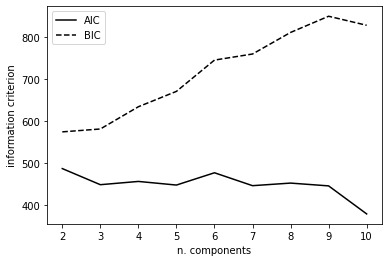

In [ ]:
ax = plt.gca()
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, '--k', label='BIC')
ax.set_xlabel('n. components')
ax.set_ylabel('information criterion')
ax.legend(loc=2);

## Weights

In [ ]:
gmm.weights_

array([0.33333333, 0.30118609, 0.36548058])

## Means

In [ ]:
gmm.means_

array([[5.006     , 3.428     , 1.462     , 0.246     ],
       [5.91697517, 2.77803998, 4.20523542, 1.29841561],
       [6.54632887, 2.94943079, 5.4834877 , 1.98716063]])

## Covariances
* Structure dependent on constraints

In [ ]:
gmm.covariances_

array([[[0.121765  , 0.097232  , 0.016028  , 0.010124  ],
        [0.097232  , 0.140817  , 0.011464  , 0.009112  ],
        [0.016028  , 0.011464  , 0.029557  , 0.005948  ],
        [0.010124  , 0.009112  , 0.005948  , 0.010885  ]],

       [[0.27550587, 0.09663458, 0.18542939, 0.05476915],
        [0.09663458, 0.09255531, 0.09103836, 0.04299877],
        [0.18542939, 0.09103836, 0.20227635, 0.0616792 ],
        [0.05476915, 0.04299877, 0.0616792 , 0.03232217]],

       [[0.38741443, 0.09223101, 0.30244612, 0.06089936],
        [0.09223101, 0.11040631, 0.08386768, 0.0557538 ],
        [0.30244612, 0.08386768, 0.32595958, 0.07283247],
        [0.06089936, 0.0557538 , 0.07283247, 0.08488025]]])

## Soft Clustering

In [ ]:
gmm.predict(X_iris)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
gmm.predict_proba(X_iris)[0:5]

array([[1.00000000e+00, 9.06516804e-44, 6.39829159e-35],
       [1.00000000e+00, 8.53836828e-31, 2.59954184e-28],
       [1.00000000e+00, 9.37295905e-36, 4.21198692e-30],
       [1.00000000e+00, 1.46701195e-31, 2.71194113e-26],
       [1.00000000e+00, 3.36751068e-46, 2.68318787e-35]])

## Initialization
* EM converges to a local optimum
* Careful initialization reduces risk of getting stuck / influenced by outliers.
* Initialization Options
  * kmeans - Responsibilities are initialized using KMeans
  * kmeans++ - Uses K-means++ to initialize
  * Random - Responsibilities initialized randomly
  * RandomFromData - Randomly selected data points

## Covariance Types
* Full - Each component has it's own covariance matrix
* Tied - All components share same covariance matrix
* Diag - Each component has it's own diagonal covariance matrix
* Spherical - Each component has its own single variance

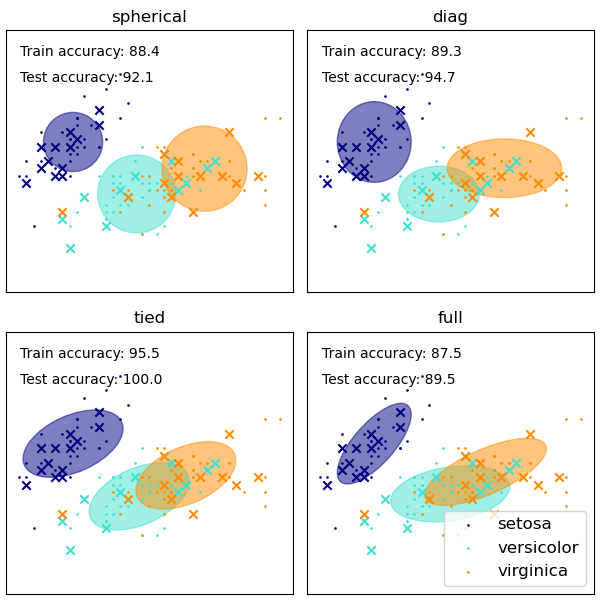

## KMeans
* GMM is a generalization of KMeans 
* Covariance is just spherical

# Variational Bayesian Gaussian Mixture

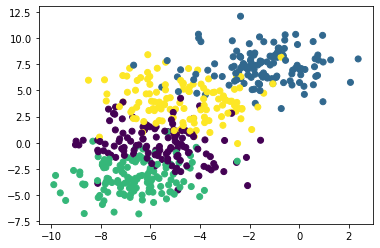

In [ ]:
X, y = make_blobs(n_samples=500, centers=4, cluster_std=1.5, random_state=22)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis');

## Fitting

In [ ]:
vgmm = BayesianGaussianMixture(n_components=10)

In [ ]:
vgmm.fit(X)

/usr/local/lib/python3.8/dist-packages/sklearn/mixture/_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


BayesianGaussianMixture(n_components=10)

In [ ]:
vgmm.weights_

array([4.44265365e-01, 2.14398059e-03, 5.98037869e-02, 2.12619407e-03,
       2.14794804e-01, 2.76670709e-01, 1.77430989e-04, 1.61300474e-05,
       1.46636794e-06, 1.33306176e-07])

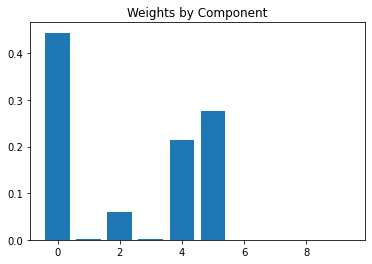

In [ ]:
plt.bar(x=[i for i in range(len(vgmm.weights_))], height=vgmm.weights_)
plt.title('Weights by Component');

## Results

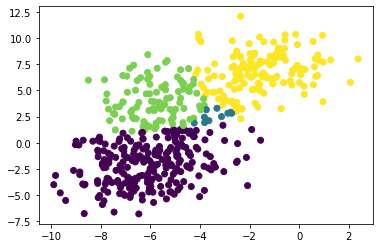

In [ ]:
pred = vgmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=pred, cmap='viridis');

## Prior
* Weight_concentration_prior is small and n_components is large the Variational GMM tends to set weights close to zero. 
* Model choose a suitable number of effective components automatically
* n_components acts as an upper bound of this number needs to be provided

In [ ]:
@interact(components=(1, 20), weight_concentration_prior=[0.001, 0.01, 0.1, 0.5, 1., 10, 100])
def set_prior(components, weight_concentration_prior):
  vgmm = BayesianGaussianMixture(n_components=components, weight_concentration_prior=weight_concentration_prior)
  vgmm.fit(X)
  pred = vgmm.predict(X)
  fig, ax = plt.subplots(1, 2, figsize=(12, 6))
  ax[0].scatter(X[:, 0], X[:, 1], c=pred, cmap='viridis')
  ax[0].set_title('Clusters');
  ax[1].bar(x=[i for i in range(len(vgmm.weights_))], height=vgmm.weights_)
  ax[1].set_title('Weights by Component');

interactive(children=(IntSlider(value=10, description='components', max=20, min=1), Dropdown(description='weig…

# Notes
* Easy to implement & available in SciKit
* Guaranteed to hit a minumum
  * Log-likihood decreases on each step
* Can add constraints through the covariance types
* Initialization is important 
* Watch out for a singularity (all / most points in one cluster)
* Have to find K (number of clusters)